### Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


### Funções

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary


### Carregando dados

In [3]:
seed = 42
file_path = '../data/outputs/costumers_feature_df.parquet'
file_path2 = '../data/outputs/feature_df.parquet'
df = load_data(file_path2)
##display(df)

rating = df['review_score_factor']
#rating = df['review_score']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_category_name_english', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor']

features = df.drop(drop_columns, axis=1)
features = features.fillna(features.mean())

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,product_category_name_english,comp_score,review_score_factor,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,9.0,2.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,2.0,0.0,0.0,1.0,7.0,5.0


### Dividindo os dados

In [5]:

x_train, x_test, y_train, y_test = train_test_split(features, rating, test_size = 0.2, random_state = seed)

### Criação e treinamento do modelo de XGBoost

In [6]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred, output_dict=True)



c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Criação e treinamento do modelo de Árvore de decisão

In [7]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

# Realização de previsões
y_pred = clf.predict(x_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
class_report_dt = classification_report(y_test, y_pred,output_dict=True)

### Criação e treinamento do modelo de regressão logística

In [8]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred_lr = model.predict(x_test)
class_report_lr = classification_report(y_test, y_pred_lr,output_dict=True)

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Criação e treinamento do modelo com regressão linear

In [9]:

reg = lm.LinearRegression().fit(x_train, y_train)

y_pred_lr = reg.predict(x_test)

score = reg.score(x_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this linear regression model is 0.13128
The RMSE in this linear regression model is 0.69711, which is about 50.0% of the mean rating score.


### Criação e treinamento do modelo com floresta aleatória

In [10]:
# Criar e treinar o modelo de floresta aleatória
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões 
y_pred_rf = model.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'The accuracy of the RF model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_rf = classification_report(y_test, y_pred_rf,output_dict=True)

The accuracy of the RF model is 0.68216


### Criação e treinamento do modelo utilizando KNN

In [11]:
# Criar e treinar o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Fazer previsões
y_pred_knn = model_knn.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'The accuracy of the KNN model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_knn = classification_report(y_test, y_pred_knn,output_dict=True)

The accuracy of the KNN model is 0.53412


### Criação e treinamento do modelo utilizando GBM

In [12]:
# Criar e treinar o modelo Gradient Boosting
model_gbm = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_gbm.fit(x_train, y_train)

# Fazer previsões
y_pred_gbm = model_gbm.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_gbm)
print(f'The accuracy of the Gradient Boosting model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_gbm = classification_report(y_test, y_pred_gbm,output_dict=True)

The accuracy of the Gradient Boosting model is 0.61284


In [13]:
data = {
    'Model': ['XGBoost', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN', 'GBM'],
    
    # Métricas por classe
    'Class 0 Precision': [0.68, 0.77, 0.57, 0.60, 0.39, 0.67],
    'Class 0 Recall': [0.50, 0.62, 0.60, 0.22, 0.33, 0.43],
    'Class 0 F1-Score': [0.58, 0.69, 0.58, 0.32, 0.36, 0.52],
    
    'Class 1 Precision': [0.56, 0.63, 0.42, 0.36, 0.36, 0.43],
    'Class 1 Recall': [0.07, 0.26, 0.42, 0.01, 0.30, 0.02],
    'Class 1 F1-Score': [0.13, 0.37, 0.42, 0.02, 0.33, 0.04],
    
    'Class 2 Precision': [0.63, 0.67, 0.68, 0.58, 0.63, 0.61],
    'Class 2 Recall': [0.95, 0.91, 0.67, 0.98, 0.71, 0.96],
    'Class 2 F1-Score': [0.75, 0.78, 0.68, 0.73, 0.67, 0.75],
    
    # Métricas agregadas
    'Accuracy': [0.63, 0.68, 0.59, 0.58, 0.53, 0.61],
    'Macro Avg Precision': [0.62, 0.69, 0.56, 0.51, 0.46, 0.57],
    'Macro Avg Recall': [0.51, 0.60, 0.56, 0.40, 0.45, 0.47],
    'Macro Avg F1-Score': [0.49, 0.61, 0.56, 0.36, 0.45, 0.43],
    'Weighted Avg Precision': [0.62, 0.68, 0.59, 0.52, 0.52, 0.57],
    'Weighted Avg Recall': [0.63, 0.68, 0.59, 0.58, 0.53, 0.61],
    'Weighted Avg F1-Score': [0.55, 0.65, 0.59, 0.47, 0.52, 0.51]
}

# Criar o DataFrame
results_df = pd.DataFrame(data)

# Exibir o DataFrame
print(results_df)

                 Model  Class 0 Precision  Class 0 Recall  Class 0 F1-Score  \
0              XGBoost               0.68            0.50              0.58   
1        Random Forest               0.77            0.62              0.69   
2        Decision Tree               0.57            0.60              0.58   
3  Logistic Regression               0.60            0.22              0.32   
4                  KNN               0.39            0.33              0.36   
5                  GBM               0.67            0.43              0.52   

   Class 1 Precision  Class 1 Recall  Class 1 F1-Score  Class 2 Precision  \
0               0.56            0.07              0.13               0.63   
1               0.63            0.26              0.37               0.67   
2               0.42            0.42              0.42               0.68   
3               0.36            0.01              0.02               0.58   
4               0.36            0.30              0.33       

C:\Users\mater\AppData\Local\Temp\ipykernel_4808\2896611172.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Class 0 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
C:\Users\mater\AppData\Local\Temp\ipykernel_4808\2896611172.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Class 0 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
C:\Users\mater\AppData\Local\Temp\ipykernel_4808\2896611172.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Class 1 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
C:\Users\mater\AppData\Local\Temp\ipykernel_4808\2896611172.py:9: FutureWarning: 

Passing `palette` without assigning

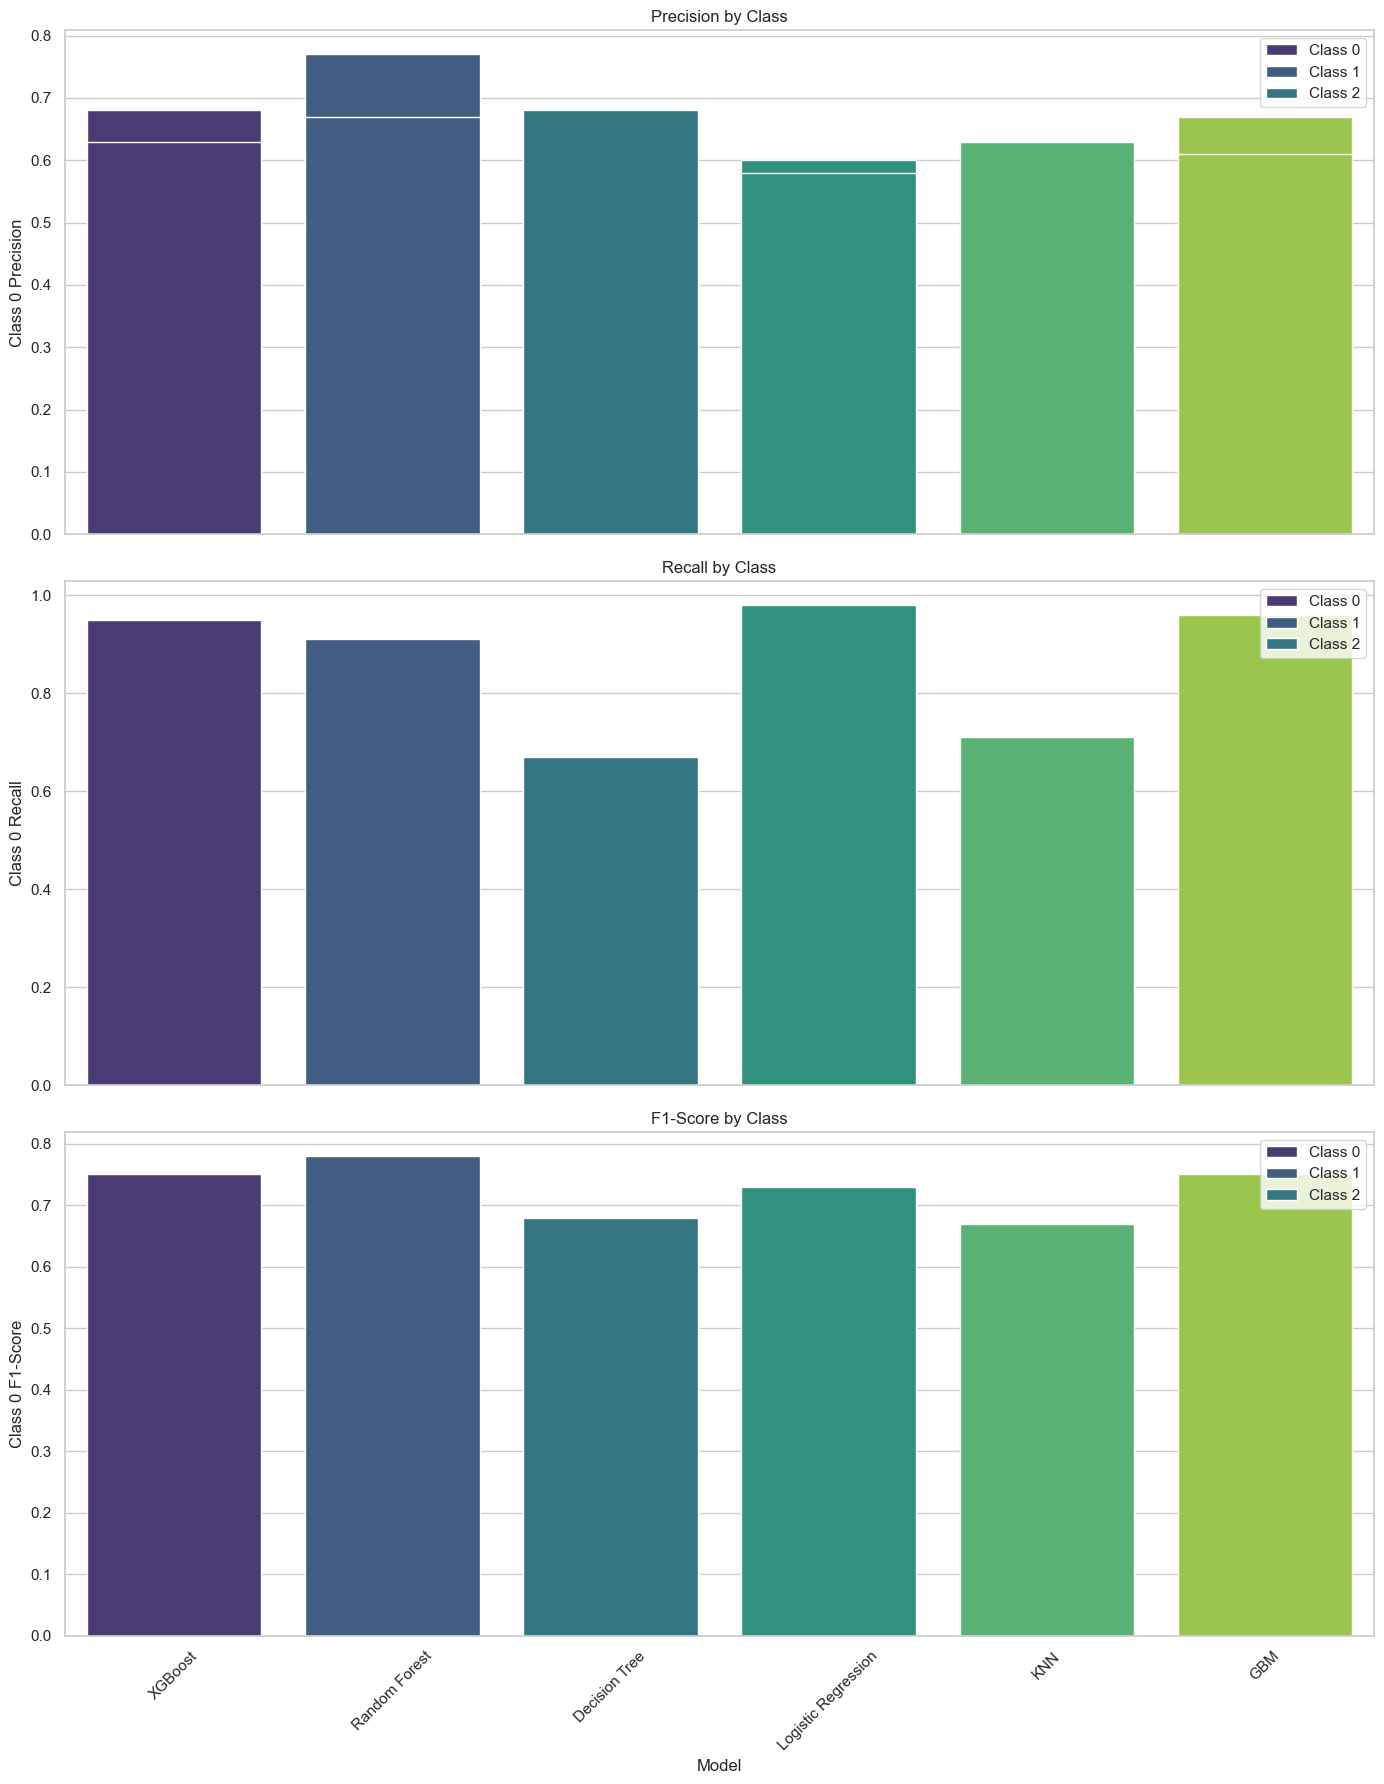

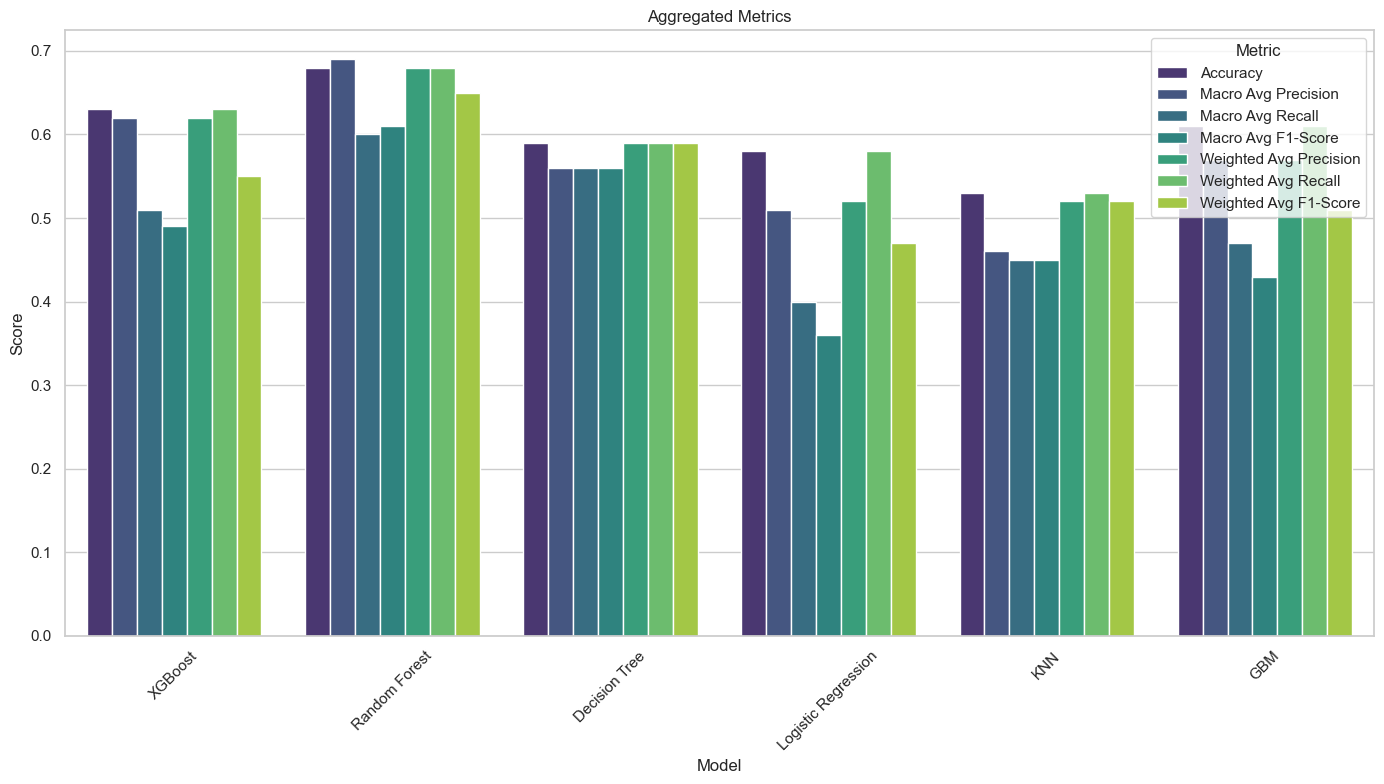

In [14]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Gráfico 1: Precisão, Recall e F1-Score por Classe
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Precisão por Classe
sns.barplot(x='Model', y='Class 0 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 1 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 2 Precision', data=results_df, ax=axes[0], palette="viridis", ci=None)
axes[0].set_title('Precision by Class')
axes[0].legend(['Class 0', 'Class 1', 'Class 2'], loc='upper right')

# Recall por Classe
sns.barplot(x='Model', y='Class 0 Recall', data=results_df, ax=axes[1], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 1 Recall', data=results_df, ax=axes[1], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 2 Recall', data=results_df, ax=axes[1], palette="viridis", ci=None)
axes[1].set_title('Recall by Class')
axes[1].legend(['Class 0', 'Class 1', 'Class 2'], loc='upper right')

# F1-Score por Classe
sns.barplot(x='Model', y='Class 0 F1-Score', data=results_df, ax=axes[2], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 1 F1-Score', data=results_df, ax=axes[2], palette="viridis", ci=None)
sns.barplot(x='Model', y='Class 2 F1-Score', data=results_df, ax=axes[2], palette="viridis", ci=None)
axes[2].set_title('F1-Score by Class')
axes[2].legend(['Class 0', 'Class 1', 'Class 2'], loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico 2: Métricas Agregadas
metrics = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score', 
           'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
metrics_df = results_df.melt(id_vars=['Model'], value_vars=metrics,
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="viridis")
plt.title('Aggregated Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()